In [22]:
import numpy as np
# Results from same day of week as in (S)ARIMA
# path with informer results
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']
for country in top_5_countries:
    path_full = f"informer_npy_results_32gb/{country}_96_24_{country}_Informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc5_ebtimeF_dtTrue_lossMAE_Exp_0"
    pred = np.load(path_full + "/pred.npy")[:, :, :]
    true = np.load(path_full + "/true.npy")[:, :, :]
    pred = pred[::168, :, :].flatten()
    true = true[::168, :, :].flatten()

    rmse = np.sqrt(np.mean((pred - true) ** 2)) 
    mae = np.mean(np.abs(pred - true)) 

    rmse = rmse*100
    mae = mae*100
    print(f"Results for only one day of week forecasting for country: {country}: RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Results for only one day of week forecasting for country: DE: RMSE: 15.79, MAE: 10.48
Results for only one day of week forecasting for country: GB: RMSE: 21.65, MAE: 13.81
Results for only one day of week forecasting for country: ES: RMSE: 17.67, MAE: 10.41
Results for only one day of week forecasting for country: FR: RMSE: 13.14, MAE: 7.10
Results for only one day of week forecasting for country: IT: RMSE: 12.09, MAE: 6.82


In [15]:
4440/5/24

37.0

In [12]:
6208/168

36.95238095238095

In [5]:
6208/168

36.95238095238095

In [6]:
6240/168

37.142857142857146

In [4]:
6240/32

195.0

In [3]:
6240-6208

32

In [ ]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']

# Dictionaries to store MSE and MAE values for each column
mse_values_dict = {}
mae_values_dict = {}

for country in top_5_countries:
    columns = [col for col in metrics_df.columns.levels[0] if col.startswith(country)]
    
    for i, col in enumerate(columns):

        # Initialize lists to store MSE and MAE values for the current column
        mse_values = []
        mae_values = []
        
        # Iterate over experiment numbers
        for j in range(2):
            path = "/Users/valentyna/Documents/Master_thesis_new/results/Informer/long_term_forecast__24_"
            path_2 = "_Informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl5_df2048_fc5_ebtimeF_dtTrue_Exp_"
            
            exp_number = j
            path_full = path + country + path_2 + str(exp_number)

            pred = np.load(path_full + "/pred.npy")[:, :, i]
            true = np.load(path_full + "/true.npy")[:, :, i]

            #mse = mean_squared_error(true, pred)
            #mae = mean_absolute_error(true, pred)
            mse = mean_squared_error(pred, true)
            mae = mean_absolute_error(pred, true)

            # Append MSE and MAE values to the lists
            mse_values.append(mse)
            mae_values.append(mae)
        
        # Store MSE and MAE values for the current column
        mse_values_dict[col] = mse_values
        mae_values_dict[col] = mae_values

In [ ]:
# code from https://github.com/ts-kim/RevIN, with minor modifications

import torch
import torch.nn as nn

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x): # B, T, C
        # 1, 2 -> 1
        dim2reduce = tuple(range(1, x.ndim-1)) # (1, )
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x


In [29]:
import torch

# Create a tensor of shape (24,) filled with numbers from 1 to 24
tensor_1d = torch.arange(1, 25)

# Reshape the 1D tensor into a 3D tensor
tensor_3d = tensor_1d.reshape(2, 3, 4).float()

print(tensor_3d)

tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]],

        [[13., 14., 15., 16.],
         [17., 18., 19., 20.],
         [21., 22., 23., 24.]]])


In [31]:
dim2reduce = tuple(range(1, tensor_3d.ndim-1)) # (1, )
mean = torch.sum(tensor_3d, dim=dim2reduce, keepdim=True)
mean

tensor([[[15., 18., 21., 24.]],

        [[51., 54., 57., 60.]]])

In [37]:
tensor_3d - mean

tensor([[[-14., -16., -18., -20.],
         [-10., -12., -14., -16.],
         [ -6.,  -8., -10., -12.]],

        [[-38., -40., -42., -44.],
         [-34., -36., -38., -40.],
         [-30., -32., -34., -36.]]])

In [ ]:
tensor3d = torch.randn(2, 5, 3)
tensor3d.shape

torch.Size([2, 32, 32, 3])

In [24]:
tensor3d.ndim

4

In [23]:
tuple(range(1, tensor3d.ndim-1))

(1, 2)

In [32]:
import torch
import numpy as np

def create_seasonal_time_series(length, period, amplitude, noise_std=0.1):
  """
  Creates a time series with a seasonal pattern.

  Args:
    length: Length of the time series.
    period: Period of the seasonal cycle.
    amplitude: Amplitude of the seasonal cycle.
    noise_std: Standard deviation of the noise.

  Returns:
    A NumPy array representing the time series.
  """

  time_steps = np.arange(length)
  seasonal_component = amplitude * np.sin(2 * np.pi * time_steps / period)
  noise = np.random.normal(0, noise_std, size=length)
  time_series = seasonal_component + noise

  return time_series

# Parameters
length = 1000
period = 10
amplitude = 5
batch_size = 32
seq_len = 200
num_features = 1

# Create the time series
time_series = create_seasonal_time_series(length, period, amplitude)

# Reshape into batches and sequences
data = []
for i in range(0, len(time_series) - seq_len, seq_len):
  data.append(time_series[i:i+seq_len])

data = np.array(data)
data = data.reshape(data.shape[0], data.shape[1], num_features)

# Convert to PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

print(data_tensor.shape)  # Output: (batch_size, seq_len, num_features)

torch.Size([4, 200, 1])


In [22]:
tensor3d = torch.randn(2, 32, 32, 3)
tensor3d.shape

torch.Size([2, 32, 32, 3])

In [33]:
r = RevIN(1)
t_1 = r(data_tensor, 'norm')
r(data_tensor, 'denorm')

tensor([[[ 3.9472e-01],
         [ 1.0329e+01],
         [ 1.6165e+01],
         [ 1.6625e+01],
         [ 9.8124e+00],
         [-1.2768e-01],
         [-9.9719e+00],
         [-1.6431e+01],
         [-1.6931e+01],
         [-1.0627e+01],
         [ 1.1993e-01],
         [ 1.0129e+01],
         [ 1.7147e+01],
         [ 1.6400e+01],
         [ 1.0625e+01],
         [-5.1404e-01],
         [-1.0290e+01],
         [-1.6664e+01],
         [-1.7094e+01],
         [-1.0143e+01],
         [ 7.6114e-01],
         [ 1.1083e+01],
         [ 1.7088e+01],
         [ 1.6828e+01],
         [ 1.0667e+01],
         [ 4.9499e-02],
         [-9.8795e+00],
         [-1.7257e+01],
         [-1.6755e+01],
         [-1.0445e+01],
         [ 4.3313e-02],
         [ 9.9738e+00],
         [ 1.7292e+01],
         [ 1.6729e+01],
         [ 1.0207e+01],
         [ 1.1382e-01],
         [-1.0542e+01],
         [-1.6858e+01],
         [-1.6799e+01],
         [-9.8826e+00],
         [-6.2300e-01],
         [ 1.044

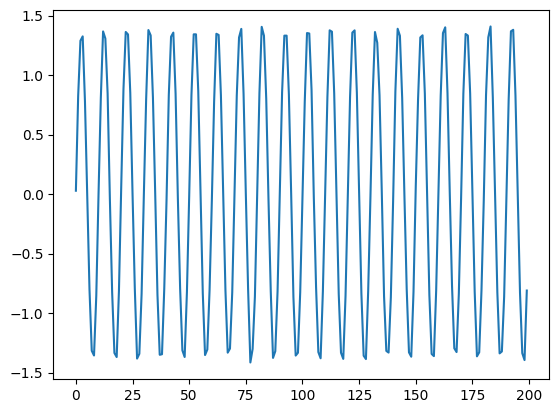

In [34]:
plt.plot(t_1[0, :, 0].detach().numpy())

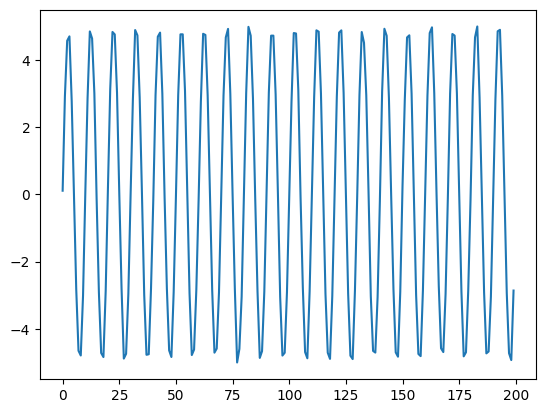

In [36]:
import matplotlib.pyplot as plt
plt.plot(data_tensor[0, :, 0].numpy())